In [2]:
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

/Users/joaopcoelho/anaconda/envs/python2/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


### Useful functions ###

In [3]:
#convert shot flags to colors
def flag_colors(flag):
    if flag == 1: return 'green'
    if flag == 0: return 'red'
    return 'black'

In [4]:
data = pd.read_csv('data.csv')

In [5]:
data.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


In [6]:
list(data.columns.values)

['action_type',
 'combined_shot_type',
 'game_event_id',
 'game_id',
 'lat',
 'loc_x',
 'loc_y',
 'lon',
 'minutes_remaining',
 'period',
 'playoffs',
 'season',
 'seconds_remaining',
 'shot_distance',
 'shot_made_flag',
 'shot_type',
 'shot_zone_area',
 'shot_zone_basic',
 'shot_zone_range',
 'team_id',
 'team_name',
 'game_date',
 'matchup',
 'opponent',
 'shot_id']

In [7]:
data.iloc[0]

action_type                    Jump Shot
combined_shot_type             Jump Shot
game_event_id                         10
game_id                         20000012
lat                              33.9723
loc_x                                167
loc_y                                 72
lon                             -118.103
minutes_remaining                     10
period                                 1
playoffs                               0
season                           2000-01
seconds_remaining                     27
shot_distance                         18
shot_made_flag                       NaN
shot_type                 2PT Field Goal
shot_zone_area             Right Side(R)
shot_zone_basic                Mid-Range
shot_zone_range                16-24 ft.
team_id                       1610612747
team_name             Los Angeles Lakers
game_date                     2000-10-31
matchup                        LAL @ POR
opponent                             POR
shot_id         

# Notes

* Can we improve the missing data strategy?
* Are all the limitations to algorithm application verified?

* prevent leakage: train only on shots prior to the ones we're predicting (year)
* select features and then explore number of neighbours

* target: score=0.75

# Preprocessing

In [42]:
# TRAINING AND TEST DATA
train_data, test_data = train_test_split(data, test_size = 0.2, random_state = 0)

In [43]:
# MISSING DATA
# don't consider rows with shot_made_flag = NaN
train_data = train_data[np.isfinite(train_data['shot_made_flag'])]
test_data = test_data[np.isfinite(test_data['shot_made_flag'])]

   # Exploring features

### Opponent

In [10]:
total_shots = pd.pivot_table(data, index="opponent", values="shot_id", aggfunc='count')

In [25]:
shots_scored = pd.pivot_table(data, index="opponent", values="shot_made_flag", aggfunc='sum')

In [26]:
accuracy = shots_scored/total_shots

In [27]:
accuracy.mean()

0.3691933909157366

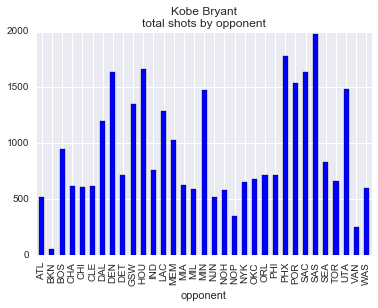

In [17]:
total_shots.plot.bar(title='Kobe Bryant\ntotal shots by opponent')

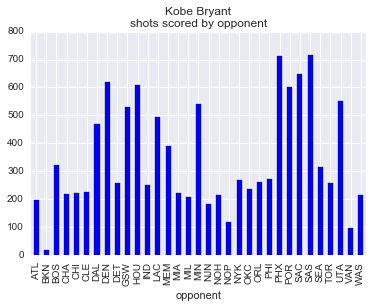

In [18]:
shots_scored.plot.bar(title='Kobe Bryant\nshots scored by opponent')

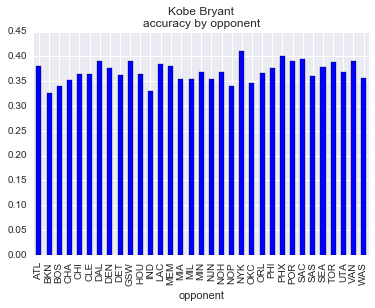

In [40]:
accuracy.plot.bar(title='Kobe Bryant\naccuracy by opponent')

#### Comments:

* The opponent doesn't seem to influence the accuracy

* also, spikes for long-time shitty teams: NYK, CLE, GSW(!), PHX, SAC

### Shots by distance

In [50]:
total_distance = pd.pivot_table(data, index="shot_distance", values="shot_id", aggfunc='count')

In [55]:
shots_scored = pd.pivot_table(data, index="shot_distance", values="shot_made_flag", aggfunc='sum')

In [56]:
accuracy = shots_scored/total_distance

[0, 30, 0, 6000]

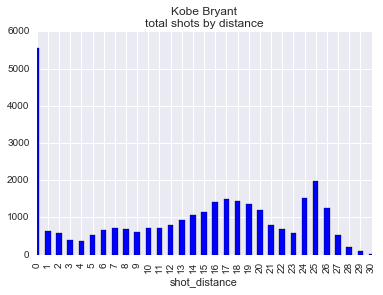

In [57]:
total_distance.plot.bar(title='Kobe Bryant\ntotal shots by distance')
plt.axis([0, 30, 0, 6000])

[0, 30, 0, 6000]

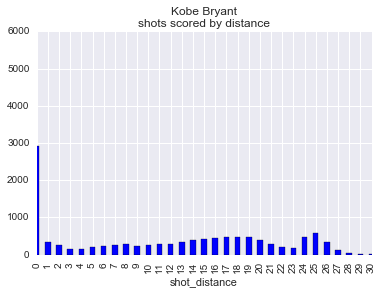

In [58]:
shots_scored.plot.bar(title='Kobe Bryant\nshots scored by distance')
plt.axis([0, 30, 0, 6000])

[0, 30, 0, 1]

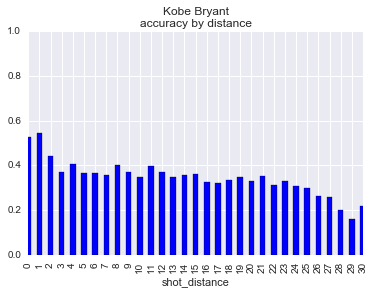

In [59]:
accuracy.plot.bar(title='Kobe Bryant\naccuracy by distance')
plt.axis([0, 30, 0, 1])

#### Comments:

* ~~Only 30 appears to have a very different percentage~~ now looking sweeter, but still not good - certainly didn't miss half his dunks for his career!

### Minutes remaining

In [48]:
minutes = pd.pivot_table(data, index="minutes_remaining", values="shot_id", aggfunc='count')

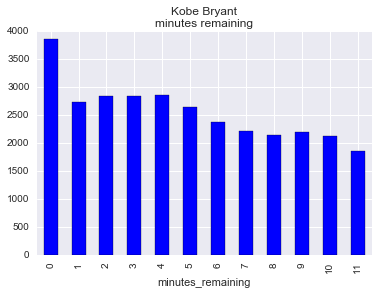

In [49]:
minutes.plot.bar(title='Kobe Bryant\nminutes remaining')

### Seconds remaining

In [50]:
seconds = pd.pivot_table(data, index="seconds_remaining", values="shot_id", aggfunc='count')

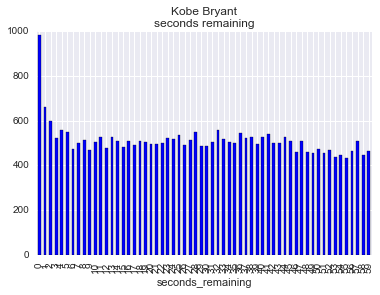

In [51]:
seconds.plot.bar(title='Kobe Bryant\nseconds remaining')

### Shots by zone range

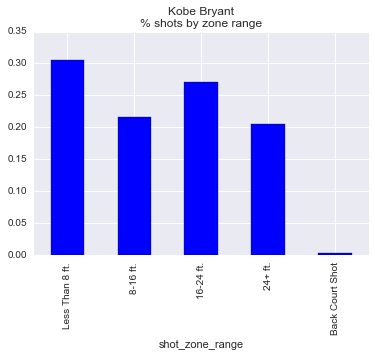

In [52]:
shot_zones = pd.pivot_table(data, index="shot_zone_range", values="shot_id", aggfunc='count')
shot_zones_pct = shot_zones/shot_zones.sum()

# change order
shot_zones_pct = shot_zones_pct.reindex(index=['Less Than 8 ft.',  u'8-16 ft.', u'16-24 ft.', u'24+ ft.', u'Back Court Shot'])
shot_zones_pct.plot.bar(title='Kobe Bryant\n% shots by zone range')

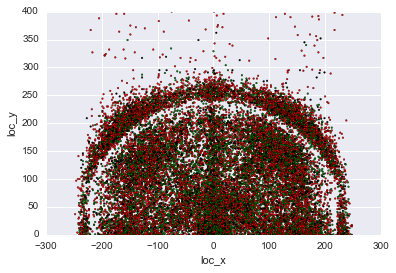

In [53]:
# let's try plotting all of his shots and show if miss or hit

shots_pos = data[['loc_x', 'loc_y']]
shot_colors = map(flag_colors, data.shot_made_flag)
shots_pos.plot.scatter(x='loc_x', y='loc_y', s=3, c=shot_colors, ylim=(0,400))

### Shots by action type

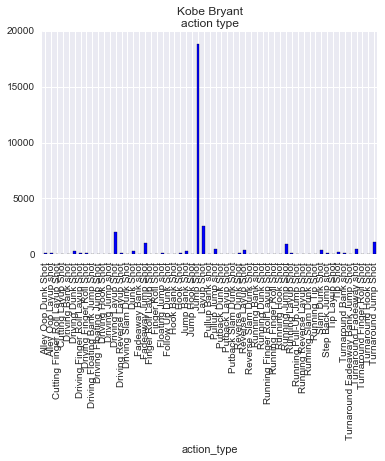

In [60]:
shots_actionType = pd.pivot_table(data, index="action_type", values="shot_id", aggfunc='count')
shots_actionType.plot.bar(title='Kobe Bryant\naction type')

In [61]:
### Combined shot type

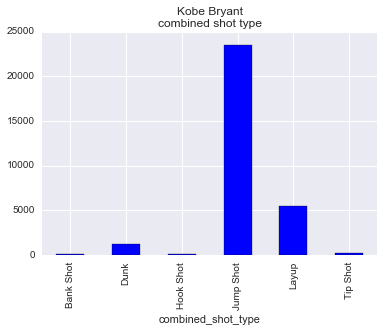

In [62]:
shots_combined = pd.pivot_table(data, index="combined_shot_type", values="shot_id", aggfunc='count')
shots_combined.plot.bar(title='Kobe Bryant\ncombined shot type')

### Shots by period

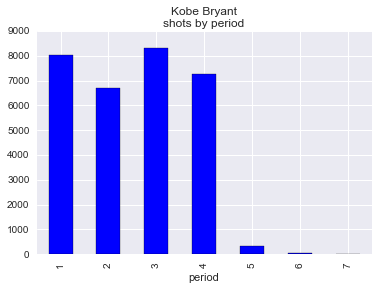

In [66]:
shots_period = pd.pivot_table(data, index="period", values="shot_id", aggfunc='count')
shots_period.plot.bar(title='Kobe Bryant\nshots by period')

### Playoffs

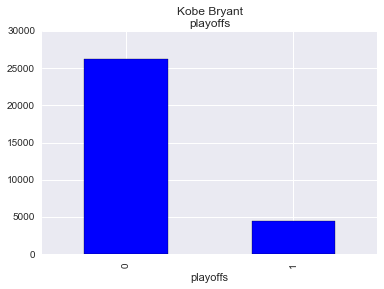

In [64]:
shots_playoffs = pd.pivot_table(data, index="playoffs", values="shot_id", aggfunc='count')
shots_playoffs.plot.bar(title='Kobe Bryant\nplayoffs')

In [65]:
# this should be in percentage

### Season

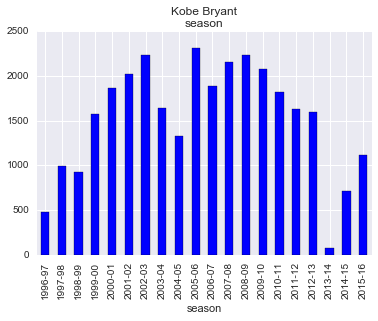

In [68]:
shots_season = pd.pivot_table(data, index="season", values="shot_id", aggfunc='count')
shots_season.plot.bar(title='Kobe Bryant\nseason')

In [69]:
# this should take into account the number of games played

### Shot type

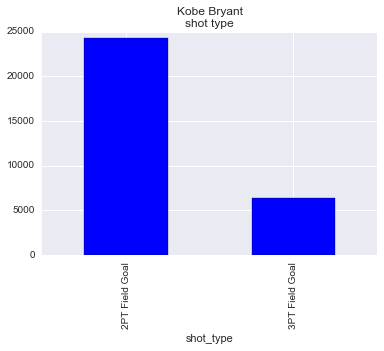

In [71]:
shots_shotType = pd.pivot_table(data, index="shot_type", values="shot_id", aggfunc='count')
shots_shotType.plot.bar(title='Kobe Bryant\nshot type')

In [72]:
# this should consider a percentage

### Missing Analysis

* Home/away
* Time of the year
* Location

# 1. kNN

** References: **
* http://scikit-learn.org/stable/modules/neighbors.html
* http://www.amazon.com/Building-Machine-Learning-Systems-Python/dp/1784392774/ref=sr_1_1?ie=UTF8&qid=1461733493&sr=8-1&keywords=luis+pedro+coelho+python

In [54]:
from sklearn import neighbors

In [55]:
knn = neighbors.KNeighborsClassifier(n_neighbors=2)

In [56]:
x1 = train_data['loc_x'].reshape(len(train_data['loc_x']),1)
x2 = train_data['loc_y'].reshape(len(train_data['loc_y']),1)
x3 = train_data['shot_distance'].reshape(len(train_data['shot_distance']),1)

In [57]:
x = np.concatenate((x1,x2,x3), axis=1)
y = train_data['shot_made_flag'].reshape(len(train_data['shot_made_flag']),1)

print x.shape
print y.shape

(20550, 3)
(20550, 1)


In [58]:
knn.fit(x,y.ravel())

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='uniform')

In [59]:
#knn.predict([0])

In [60]:
#knn.predict_proba([0])

## 1.1 kNN evaluation

In [61]:
x1_test = test_data['loc_x'].reshape(len(test_data['loc_x']),1)
x2_test = test_data['loc_y'].reshape(len(test_data['loc_y']),1)
x3_test = test_data['shot_distance'].reshape(len(test_data['shot_distance']),1)

In [62]:
x_test = np.concatenate((x1_test,x2_test,x3_test), axis=1)
y_test = test_data['shot_made_flag'].reshape(len(test_data['shot_made_flag']),1)

In [63]:
knn.score(x_test,y_test)

0.57159510394404511

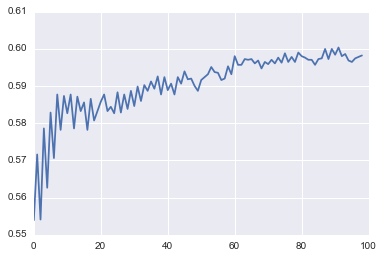

In [64]:
# try different numbers of neighbours
l = []
for i in xrange(1,100):
    knn = neighbors.KNeighborsClassifier(n_neighbors=i)
    knn.fit(x,y.ravel())
    
    sc = knn.score(x_test,y_test)
    l.append(sc)
    
plt.plot(l)